M3. Bag of Visual Words Activity
--

In [1]:
import cv2
import numpy as np
import cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os
from matplotlib import pyplot as plt

In [21]:
NUMBER_OF_SIFT_FEATURES = 800
VOCABULARY_SIZE = 128
NUMBER_OF_NEIGHBOURS = 15
DISTANCE_METRIC = 'braycurtis'
DENSE_STEP_SIZE = 8
DENSE_SIZE = 8

We now load the image data

In [3]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

TESTING
--
To finetune the Bag of Visual Words we will try different test:

1. Use vanilla SIFT and try different number of features
2. Try different distance metrics
3. Try different values of K for the KNN
4. Use dense SIFT with the best parameters
5. Try how PCA or LDA can improve the results

For each test, the loop is always the same, only the parameters change. The steps are the following:

1. We create a SIFT object detector and descriptor.
2. Compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together.
3. Compute a k-means clustering on the descriptor space
4. For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.
5. We build a k-nn classifier and train it with the train descriptors
6. Compute the test descriptors and compute the accuracy of the model

Use vanilla SIFT and try different number of features
--

In [6]:
result = []
sift_features = [100,250,500,600,700,800,1000,1250,1500,2500,5000]
for n,nosf in enumerate(sift_features):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=nosf)
    Train_descriptors = []
    Train_label_per_descriptor = []
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    k = VOCABULARY_SIZE
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knn.fit(visual_words, train_labels)
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.
Configuration 8 Done.
Configuration 9 Done.
Configuration 10 Done.
Configuration 11 Done.


Plot Results for different number of Sift Features and other fix values.

[80, 5500, 40, 70]

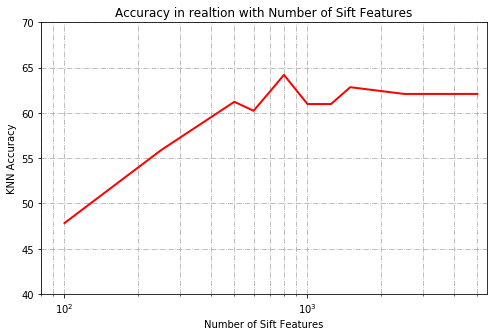

In [16]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy3')
plt.plot(sift_features,result,'r',linewidth=2)
plt.xscale('log')
plt.xlabel('Number of Sift Features')
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')
plt.axis([80,5500,40,70])

We can see that the performance of the k-nn classifier improves with the number of SIFT features, up to a certain point. The explanation behind this is that too few features do not represent appropriately the different characteristics of each class, provided that the particular characteristics that allow discriminating between classes do not get to be considered. On the other hand,  if we include those characteristics that are not representative of the class, the number of which increases with the amount of feature points, we also do not represent each class appropriately, as certain specific characteristics of particular images in each class will be considered, which leads to a bad representation of the data. Therefore, we must find a tradeoff which, in this case, seems to yield the best results when considering a maximum of 600-800 feature points per image.

In [45]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=NUMBER_OF_SIFT_FEATURES)
Train_descriptors = []
Train_label_per_descriptor = []
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)
D=np.vstack(Train_descriptors)
k = VOCABULARY_SIZE
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

Try different distance metrics
--

In [33]:
result = []
distances = ['euclidean','manhattan','chebyshev','hamming','canberra','braycurtis']
for n, dist in enumerate(distances):
    knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=dist)
    knn.fit(visual_words, train_labels)
    visual_words_test = np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.


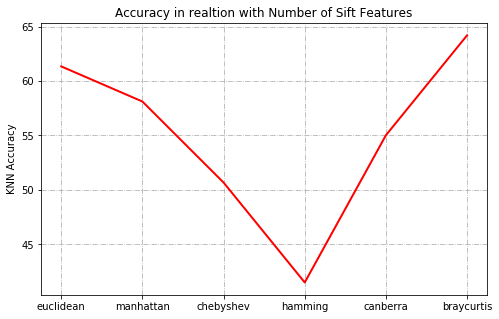

In [34]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy')
plt.plot(distances,result,'r',linewidth=2)
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')

We can see that the Bray Curtis dissimilarity performs slightly better than the Euclidean distance, for some reason. The reason could be that Bray Curtis takes into account the relation between classes (using the elements common in two classes), which fits better the data into classes. Whereas Euclidean distance just computes how distant the elements are from each other.

Try different values of Neighbours for the KNN
--

In [35]:
result = []
neighbours = [3,5,9,11,15,21,27,35,50]
for n, nb in enumerate(neighbours):
    knn = KNeighborsClassifier(n_neighbors=nb,n_jobs=-1,metric=DISTANCE_METRIC)
    knn.fit(visual_words, train_labels)
    visual_words_test = np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.
Configuration 8 Done.
Configuration 9 Done.


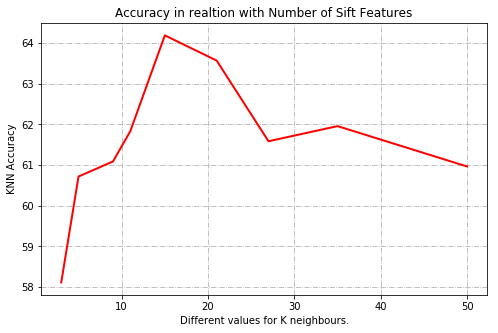

In [38]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy')
plt.plot(neighbours,result,'r',linewidth=2)
plt.xlabel('Different values for K neighbours.')
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')

Regarding the number of neighbours, we should chose it to be large enough so that the noise in the data is minimized, but small enough so that samples from other classes are not included. In this case, considering a number of neighbours around 15(+-4) seems to yield better results.

Regarding the vocabulary size, a large value results in feature vectors with a significantly high number of zeros, which require more memory and computational resources, as well as difficulting the comparison between them, given that similar "visual words" might be considered separately. If the vocabulary size is too small, feature vectors from different classes might be too close to one another, given that they might share a significant amount of similar "visual words". Therefore, this parameter must allow the feature vector to contain enough information to distinguish between classes and, at the same time, not too much information so that slightly different images from the same class do not appear far away in the feature space. In this case, considering a vocabulary of 128 visual words seems to work well.

Use Dense SIFT with the best parameters
--

In [13]:
result = []
steps = [8,12,16,24,32,64,128]
for n,dsteps in enumerate(steps):
    SIFTdetector = cv2.xfeatures2d.SIFT_create()
    Train_descriptors = []
    Train_label_per_descriptor = []
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt = [cv2.KeyPoint(x, y, dsteps) for y in range(0, gray.shape[0], dsteps) 
                                          for x in range(0, gray.shape[1], dsteps)]
        kpt,des = SIFTdetector.compute(gray, kpt)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    k = VOCABULARY_SIZE
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knn.fit(visual_words, train_labels)
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt = [cv2.KeyPoint(x, y, dsteps) for y in range(0, gray.shape[0], dsteps) 
                                          for x in range(0, gray.shape[1], dsteps)]
        kpt,des = SIFTdetector.compute(gray, kpt)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    result.append(100*knn.score(visual_words_test, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.


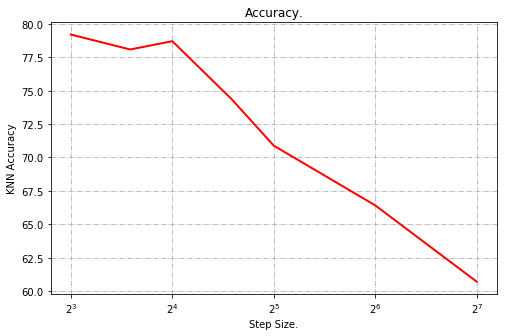

In [14]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy.')
plt.plot(steps,result,'r',linewidth=2)
plt.xscale('log',basex=2)
plt.xlabel('Step Size.')
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')

Observing the graph we see that Dense Sift performs better when more keypoints are computed than using very separate keypoints. This is due in part because using less keypoints (keypoints farther apart) generate more information than using a high separation between keypoints which seems to decrease a lot the accuracy. 

We also have to keep in mind that using a low distances netween keyoints increases the computation cost, so we will need to chose a value that achieves good accuracy with more distance as possible in this case taking keypoints 16 pixels apart seems to work very well.

Try how PCA or LDA can improve the results
--

In [22]:
SIFTdetector = cv2.xfeatures2d.SIFT_create()
Train_descriptors = []
Train_label_per_descriptor = []
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = [cv2.KeyPoint(x, y, DENSE_SIZE) for y in range(0, gray.shape[0], DENSE_STEP_SIZE) 
                                          for x in range(0, gray.shape[1], DENSE_STEP_SIZE)]
    kpt,des = SIFTdetector.compute(gray, kpt)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)
D=np.vstack(Train_descriptors)
k = VOCABULARY_SIZE
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)
knn = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
knn.fit(visual_words, train_labels)
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = [cv2.KeyPoint(x, y, DENSE_SIZE) for y in range(0, gray.shape[0], DENSE_STEP_SIZE) 
                                          for x in range(0, gray.shape[1], DENSE_STEP_SIZE)]
    kpt,des = SIFTdetector.compute(gray, kpt)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)
print(100*knn.score(visual_words_test, test_labels))

79.182156133829


PCA
--

In [34]:
result = []
components = [4,8,12,16,24,32,48,64,72,80,96,108,116]
for n,comp in enumerate(components):
    pca = PCA(n_components=comp)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knnpca.fit(VWpca, train_labels) 
    vwtestpca = pca.transform(visual_words_test)
    result.append(100*knnpca.score(vwtestpca, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.
Configuration 8 Done.
Configuration 9 Done.
Configuration 10 Done.
Configuration 11 Done.
Configuration 12 Done.
Configuration 13 Done.


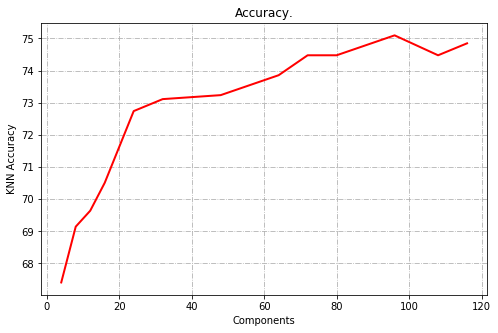

In [35]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy.')
plt.plot(components,result,'r',linewidth=2)
plt.xlabel('Components')
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')

In theory when applying PCA we need to choose a value not too high or not too low. If it is too low there woul dnot be enough features to represent the space, they will be the most significant but will not describe well the space. If it is too high we will features that will not be relevant making the accuracy drop. We need to choose a value that achieves to reduce the number of features to the ones that are the more representive.

Applying PCA does not seem to increase the current best accuracy, instead decreases it for all possible values. This means that all the features we have (128) are in a sense relevant and decreasing the features will result in lower accuracy.

LDA
--

In [44]:
result = []
components = [2,3,4,5,6,7,8]
for n,comp in enumerate(components):
    lda = LinearDiscriminantAnalysis(n_components=comp)
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=NUMBER_OF_NEIGHBOURS,n_jobs=-1,metric=DISTANCE_METRIC)
    knnlda.fit(VWlda, train_labels) 
    vwtestlda = lda.transform(visual_words_test)
    result.append(100*knnlda.score(vwtestlda, test_labels))
    print('Configuration {0} Done.'.format(n+1))

Configuration 1 Done.
Configuration 2 Done.
Configuration 3 Done.
Configuration 4 Done.
Configuration 5 Done.
Configuration 6 Done.
Configuration 7 Done.


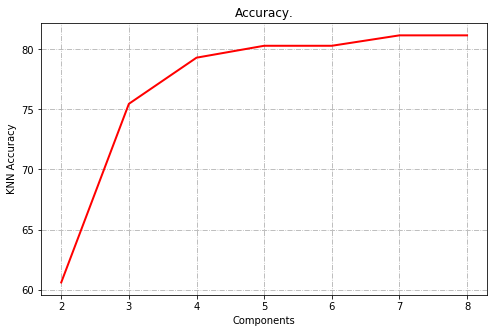

In [45]:
plt.figure(figsize=(8, 5))
plt.title('Accuracy.')
plt.plot(components,result,'r',linewidth=2)
plt.xlabel('Components')
plt.ylabel('KNN Accuracy')
plt.grid(True,which='both',linestyle='-.')

In the case of LDA we want to separate as much as possible the clusters, to do that we want to increase the distance across different classes and decrease the variance between the items of the same class.

We note that the maximum number of features that LDA allows is the number of classes-1, as taking a higher value is not possible to separate the available clusters in more clusters.

In this graph we see that choosing only 2 features does not help, as they are too few to be able to distinguish between classes. While increasing the number of features results in a increase of the overall accuracy. Seems that choosing 7 features works best.

Final Conclusions
--
We have found that the following parameters give the best accuracy:
    1. Using Dense SIFT works best than vanilla SIFT with 800 features
    2. Take keypoints 8 pixels apart from each other to compute Dense SIFT
    3. Use Bray Curtis distance as it rewards or takes into account separation of clusters.
    4. Use LDA with 7 features.

In [49]:
print(result[-1])

81.16480793060718
